In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

# Import Data

In [2]:
dataNorm = ad.read_h5ad('/data/rudensky/EYW/SIG04_240816/python_outs/SIG04_merge_singlets_ZscoreNorm_scanpy.h5ad')
dataSCT = ad.read_h5ad('/data/rudensky/EYW/SIG04_240816/python_outs/SIG04_merge_singlets_ZscoreSCT_scanpy.h5ad')

# Export RNA HVG Matrix
For Zscore and log1p umi normalized

In [ ]:
adata = dataNorm.copy()
sc.pp.filter_genes(adata, min_cells=len(adata)*0.05)
adata_hv = adata[:, adata.var['highly_variable']]
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()
mean_aggregated.to_csv('/data/rudensky/EYW/git_projects/SIG04_240816/analysis_outs/mean_aggregated_normUMI_Zscore.csv')

/scratch/lsftmp/9401554.tmpdir/ipykernel_295102/2754253017.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


# Correlation Clustering without Pooled Samples

## Clustering using full dataset + normalized counts (not Zscore)

In [3]:
adata = dataNorm.copy()
adata.X = adata.layers['log1p_norm'].copy()
# filter for genes only in X percent of cells
sc.pp.filter_genes(adata, min_cells=len(adata)*0.05)
# Subset anndata to highly-variable genes
adata_hv = adata[:, adata.var['highly_variable']]

# Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

# import metadata
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv")
meta = meta[~meta['oBC_feature_call'].str.contains('-pool')]
meta['oBC_feature_call'] = meta['oBC_feature_call'].astype("category")

# merge metadata with correlation matrix
merge = correlation_matrix.reset_index().merge(meta, on='oBC_feature_call')
merge.set_index('oBC_feature_call', inplace=True)

# create metadata labels
# create scale for MFI
norm = mcolors.Normalize(vmin=merge['mBaojin_MFI_log10'].min(),
                         vmax=merge['mBaojin_MFI_log10'].max())
cmap = sns.color_palette("viridis", as_cmap=True)  # Or use another palette like "viridis"

# create dict for categorical variables
rowID = dict(zip(merge.row.unique(),
                 sns.color_palette("Dark2",len(merge.row.unique()))))
colID = dict(zip(merge.column.unique(),
                 sns.color_palette("Set3",len(merge.column.unique()))))

anno = pd.DataFrame({
    'row_ID': merge.row.map(rowID),
    'col_ID': merge.column.map(colID),
    'expression': merge['mBaojin_MFI_log10'].map(lambda x: cmap(norm(x)))
})

/scratch/lsftmp/9401554.tmpdir/ipykernel_295102/3982686109.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


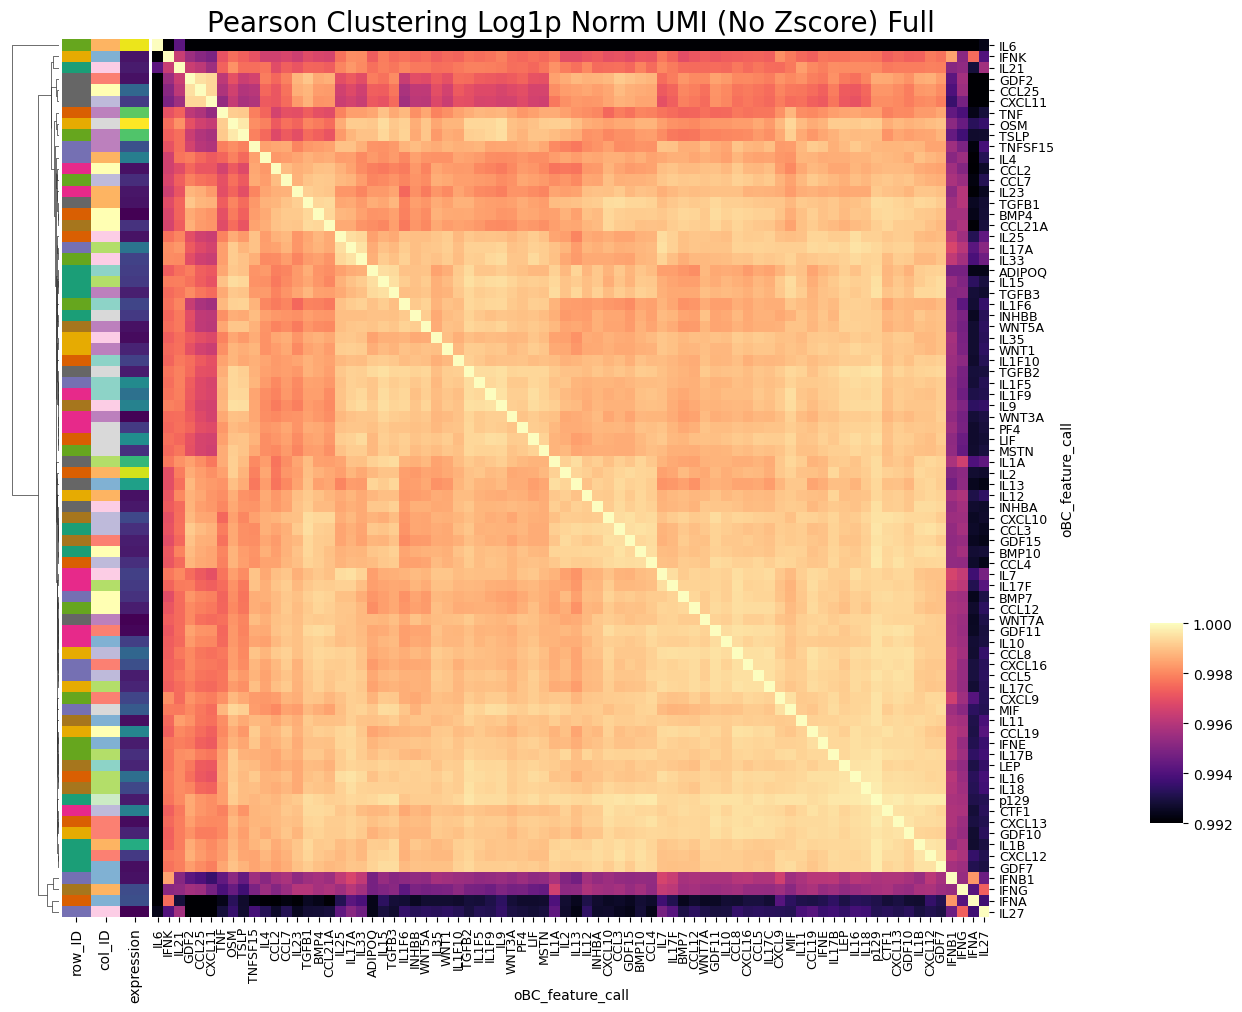

In [9]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='magma', 
                   vmin=0.992, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(11, 10),
                   row_colors=anno)

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering Log1p Norm UMI (No Zscore) Full', fontsize=20)

plt.show()

## Clustering using full dataset + normalized counts

In [177]:
adata = dataNorm.copy()
# filter for genes only in X percent of cells
sc.pp.filter_genes(adata, min_cells=len(adata)*0.05)
# Subset anndata to highly-variable genes
adata_hv = adata[:, adata.var['highly_variable']]

# Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

# import metadata
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv")
meta = meta[~meta['oBC_feature_call'].str.contains('-pool')]
meta['oBC_feature_call'] = meta['oBC_feature_call'].astype("category")

# merge metadata with correlation matrix
merge = correlation_matrix.reset_index().merge(meta, on='oBC_feature_call')
merge.set_index('oBC_feature_call', inplace=True)

# create metadata labels
# create scale for MFI
norm = mcolors.Normalize(vmin=merge['mBaojin_MFI_log10'].min(),
                         vmax=merge['mBaojin_MFI_log10'].max())
cmap = sns.color_palette("viridis", as_cmap=True)  # Or use another palette like "viridis"

# create dict for categorical variables
rowID = dict(zip(merge.row.unique(),
                 sns.color_palette("Dark2",len(merge.row.unique()))))
colID = dict(zip(merge.column.unique(),
                 sns.color_palette("Set3",len(merge.column.unique()))))

anno = pd.DataFrame({
    'row_ID': merge.row.map(rowID),
    'col_ID': merge.column.map(colID),
    'expression': merge['mBaojin_MFI_log10'].map(lambda x: cmap(norm(x)))
})

/scratch/lsftmp/9375102.tmpdir/ipykernel_15601/3012057857.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


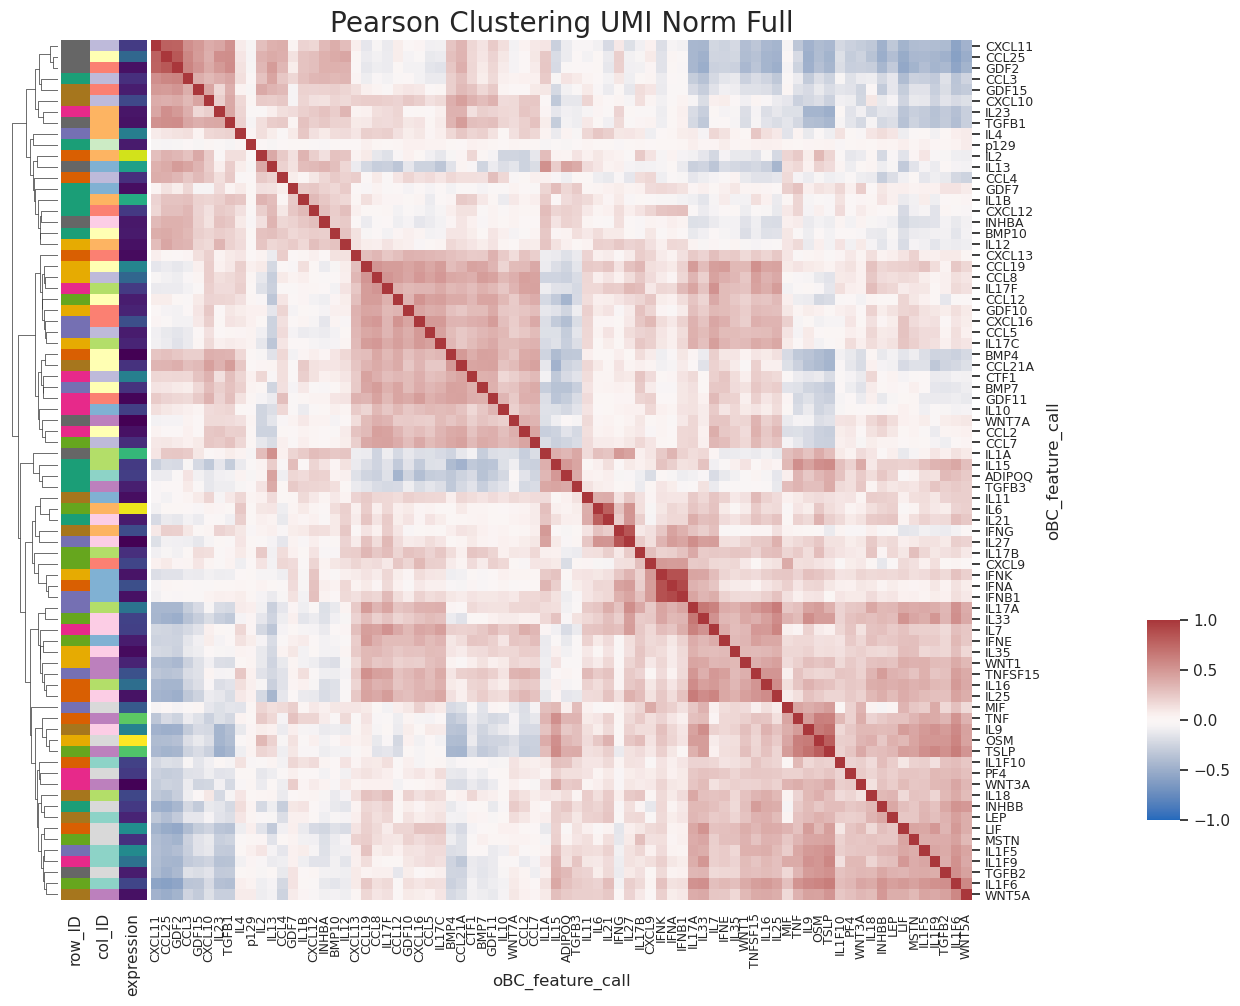

In [178]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(11, 10),
                   row_colors=anno)

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering UMI Norm Full', fontsize=20)

plt.show()

## Clustering using lane 2 only + norm counts
Interested in this because lane2 is sorted samples so perhaps signals are stronger

In [175]:
# Subset the highly-variable genes
adata = dataNorm[dataNorm.obs['gem_group'] == "lane2",:].copy()
# filter for genes only in X percent of cells
sc.pp.filter_genes(adata, min_cells=len(adata)*0.05)
# Subset anndata to highly-variable genes
adata_hv = adata[:, adata.var['highly_variable']]

# Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

# import metadata
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv")
meta = meta[~meta['oBC_feature_call'].str.contains('-pool')]
meta['oBC_feature_call'] = meta['oBC_feature_call'].astype("category")

# merge metadata with correlation matrix
merge = correlation_matrix.reset_index().merge(meta, on='oBC_feature_call')
merge.set_index('oBC_feature_call', inplace=True)

# create metadata labels
# create scale for MFI
norm = mcolors.Normalize(vmin=merge['mBaojin_MFI_log10'].min(),
                         vmax=merge['mBaojin_MFI_log10'].max())
cmap = sns.color_palette("viridis", as_cmap=True)  # Or use another palette like "viridis"

# create dict for categorical variables
rowID = dict(zip(merge.row.unique(),
                 sns.color_palette("Dark2",len(merge.row.unique()))))
colID = dict(zip(merge.column.unique(),
                 sns.color_palette("Set3",len(merge.column.unique()))))

anno = pd.DataFrame({
    'row_ID': merge.row.map(rowID),
    'col_ID': merge.column.map(colID),
    'expression': merge['mBaojin_MFI_log10'].map(lambda x: cmap(norm(x)))
})

/scratch/lsftmp/9375102.tmpdir/ipykernel_15601/3295007726.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


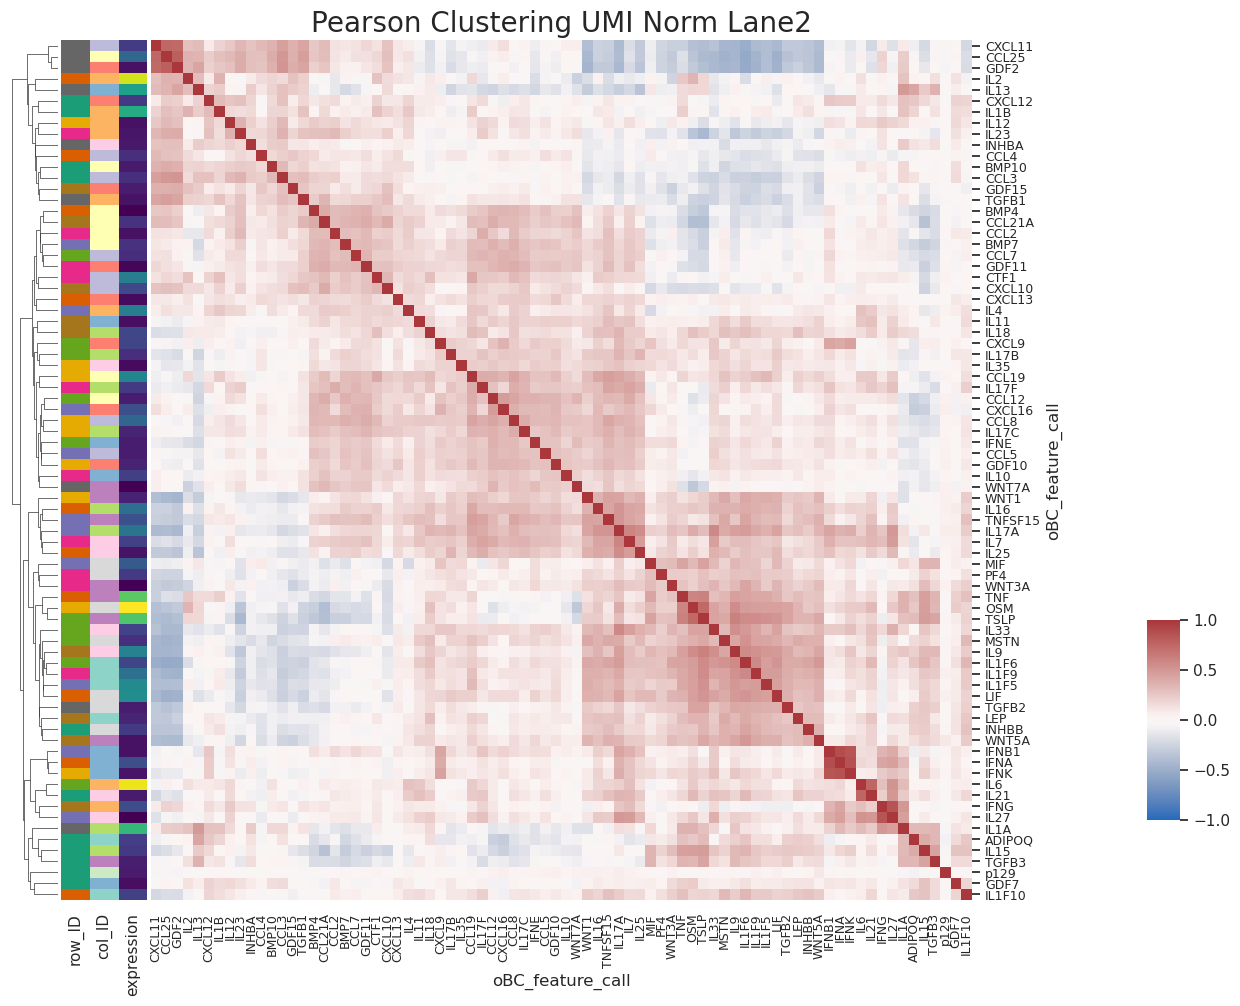

In [176]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(11, 10),
                   row_colors=anno)

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering UMI Norm Lane2', fontsize=20)

plt.show()

## Clustering using lane 1 only + norm counts

In [179]:
# Subset the highly-variable genes
adata = dataNorm[dataNorm.obs['gem_group'] == "lane1",:].copy()
# filter for genes only in X percent of cells
sc.pp.filter_genes(adata, min_cells=len(adata)*0.05)
# Subset anndata to highly-variable genes
adata_hv = adata[:, adata.var['highly_variable']]

# Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

# import metadata
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv")
meta = meta[~meta['oBC_feature_call'].str.contains('-pool')]
meta['oBC_feature_call'] = meta['oBC_feature_call'].astype("category")

# merge metadata with correlation matrix
merge = correlation_matrix.reset_index().merge(meta, on='oBC_feature_call')
merge.set_index('oBC_feature_call', inplace=True)

# create metadata labels
# create scale for MFI
norm = mcolors.Normalize(vmin=merge['mBaojin_MFI_log10'].min(),
                         vmax=merge['mBaojin_MFI_log10'].max())
cmap = sns.color_palette("viridis", as_cmap=True)  # Or use another palette like "viridis"

# create dict for categorical variables
rowID = dict(zip(merge.row.unique(),
                 sns.color_palette("Dark2",len(merge.row.unique()))))
colID = dict(zip(merge.column.unique(),
                 sns.color_palette("Set3",len(merge.column.unique()))))

anno = pd.DataFrame({
    'row_ID': merge.row.map(rowID),
    'col_ID': merge.column.map(colID),
    'expression': merge['mBaojin_MFI_log10'].map(lambda x: cmap(norm(x)))
})

/scratch/lsftmp/9375102.tmpdir/ipykernel_15601/484133847.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


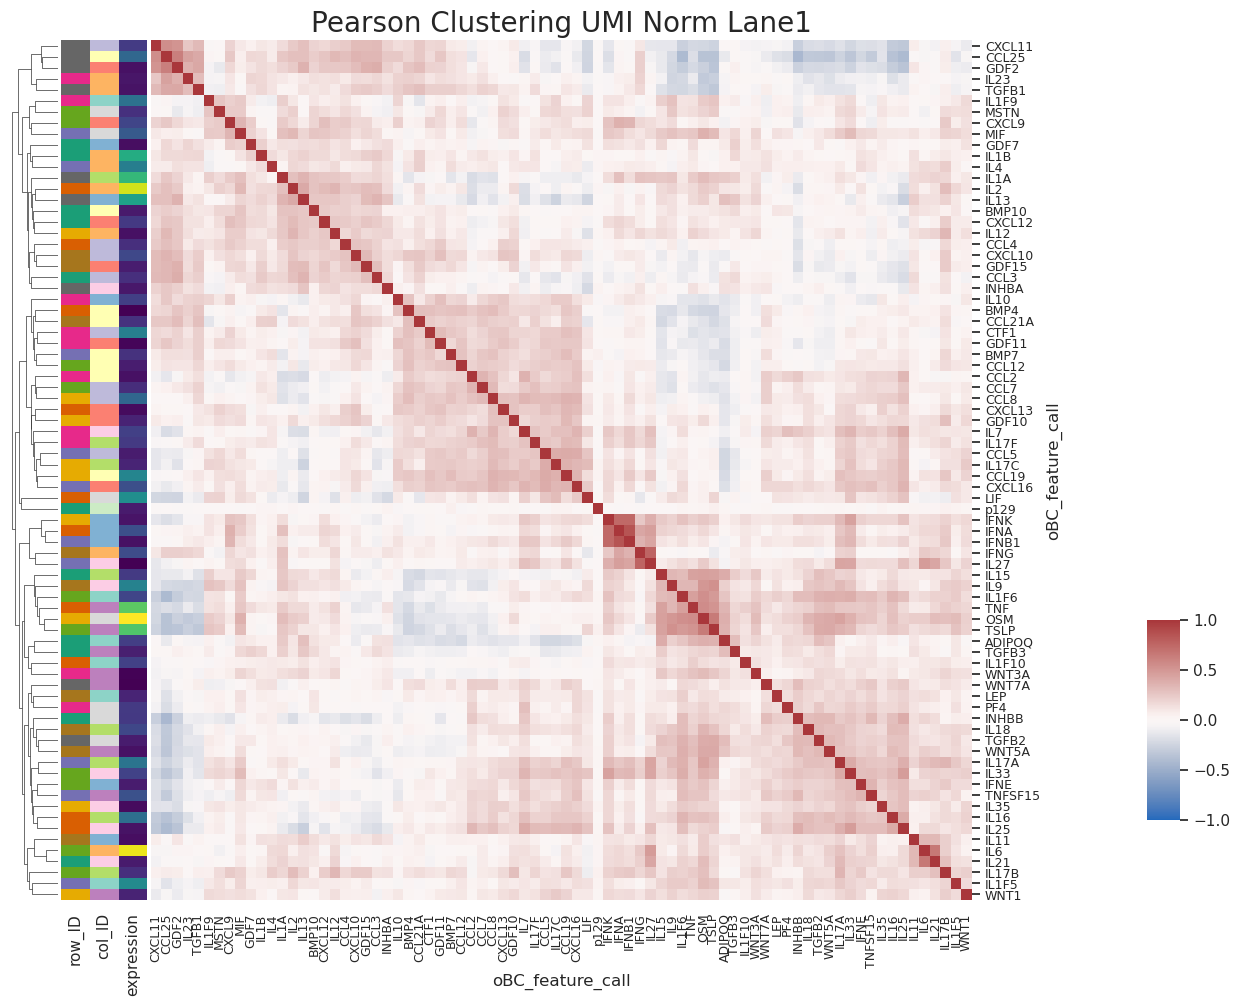

In [180]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(11, 10),
                   row_colors=anno)

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering UMI Norm Lane1', fontsize=20)

plt.show()

## Clustering using full + Pearson residuals

In [130]:
# Step 1: Subset the highly-variable genes
adata_hv = dataSCT[:, dataSCT.var['highly_variable']]

# Step 2: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_hv.X.toarray(), index=adata_hv.obs.index, columns=adata_hv.var_names)
df['oBC_feature_call'] = adata_hv.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 3: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

# import metadata
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv")
meta = meta[~meta['oBC_feature_call'].str.contains('-pool')]
meta['oBC_feature_call'] = meta['oBC_feature_call'].astype("category")

# merge metadata with correlation matrix
merge = correlation_matrix.reset_index().merge(meta, on='oBC_feature_call')
merge.set_index('oBC_feature_call', inplace=True)

# create metadata labels
# create scale for MFI
norm = mcolors.Normalize(vmin=merge['mBaojin_MFI_log10'].min(),
                         vmax=merge['mBaojin_MFI_log10'].max())
cmap = sns.color_palette("viridis", as_cmap=True)  # Or use another palette like "viridis"

# create dict for categorical variables
rowID = dict(zip(merge.row.unique(),
                 sns.color_palette("Dark2",len(merge.row.unique()))))
colID = dict(zip(merge.column.unique(),
                 sns.color_palette("Set3",len(merge.column.unique()))))

anno = pd.DataFrame({
    'row_ID': merge.row.map(rowID),
    'col_ID': merge.column.map(colID),
    'expression': merge['mBaojin_MFI_log10'].map(lambda x: cmap(norm(x)))
})

/scratch/lsftmp/9375102.tmpdir/ipykernel_15601/219846286.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


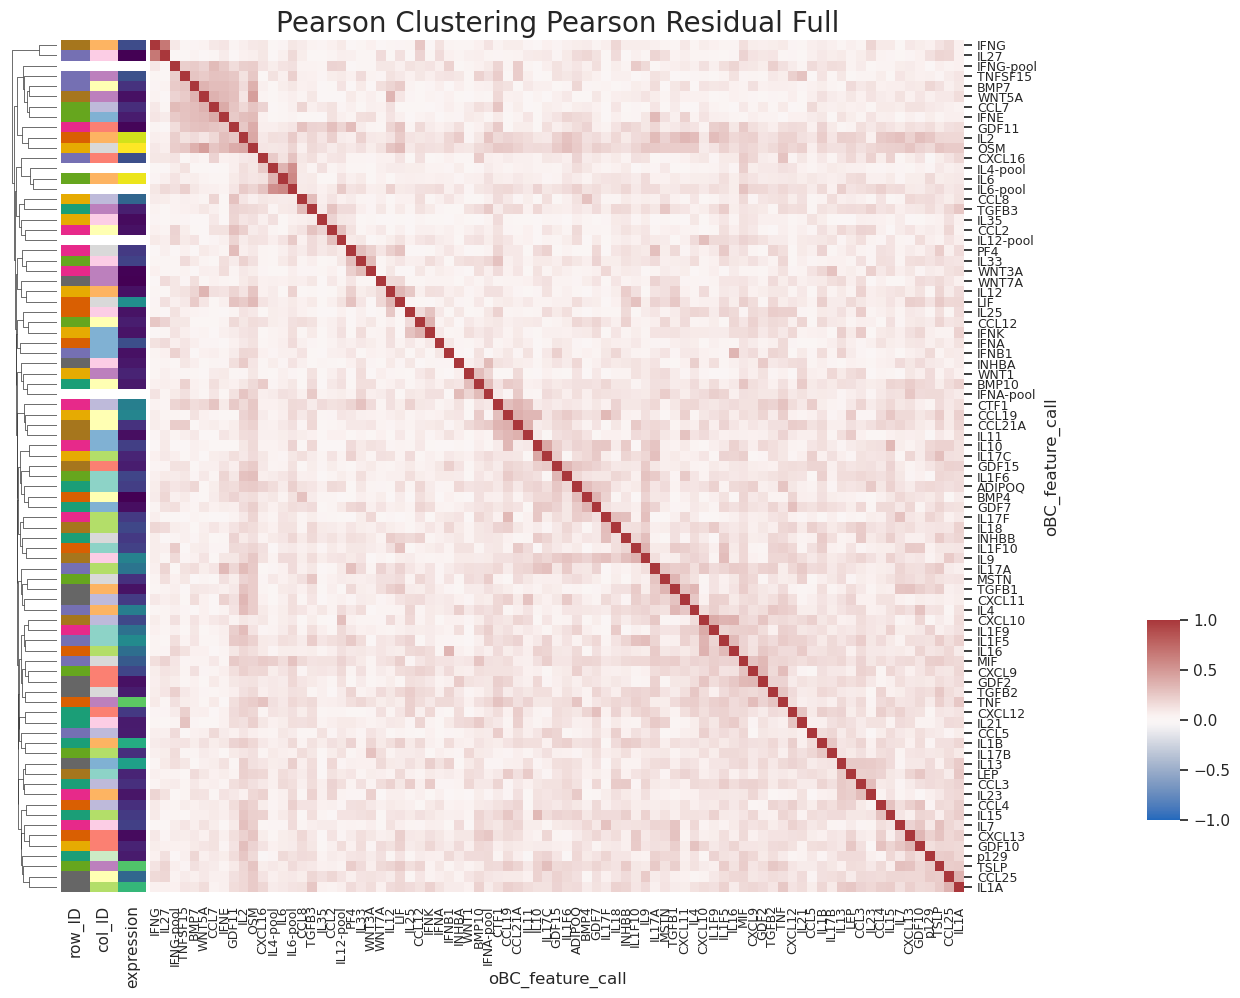

In [131]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(11, 10),
                   row_colors=anno)

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering Pearson Residual Full', fontsize=20)

plt.show()

## Clustering using lane2 + Pearson residuals

In [132]:
# Step 1: Subset the highly-variable genes
adata = dataSCT[dataSCT.obs['gem_group'] == "lane2",:]
adata_hv = adata[:, adata.var['highly_variable']]

# Step 2: Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[~adata_hv.obs['oBC_feature_call'].str.contains('-pool')]

# Step 3: Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Step 4: Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

# import metadata
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/plate_meta_SIG04.csv")
meta = meta[~meta['oBC_feature_call'].str.contains('-pool')]
meta['oBC_feature_call'] = meta['oBC_feature_call'].astype("category")

# merge metadata with correlation matrix
merge = correlation_matrix.reset_index().merge(meta, on='oBC_feature_call')
merge.set_index('oBC_feature_call', inplace=True)

# create metadata labels
# create scale for MFI
norm = mcolors.Normalize(vmin=merge['mBaojin_MFI_log10'].min(),
                         vmax=merge['mBaojin_MFI_log10'].max())
cmap = sns.color_palette("viridis", as_cmap=True)  # Or use another palette like "viridis"

# create dict for categorical variables
rowID = dict(zip(merge.row.unique(),
                 sns.color_palette("Dark2",len(merge.row.unique()))))
colID = dict(zip(merge.column.unique(),
                 sns.color_palette("Set3",len(merge.column.unique()))))

anno = pd.DataFrame({
    'row_ID': merge.row.map(rowID),
    'col_ID': merge.column.map(colID),
    'expression': merge['mBaojin_MFI_log10'].map(lambda x: cmap(norm(x)))
})

/scratch/lsftmp/9375102.tmpdir/ipykernel_15601/2155037939.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


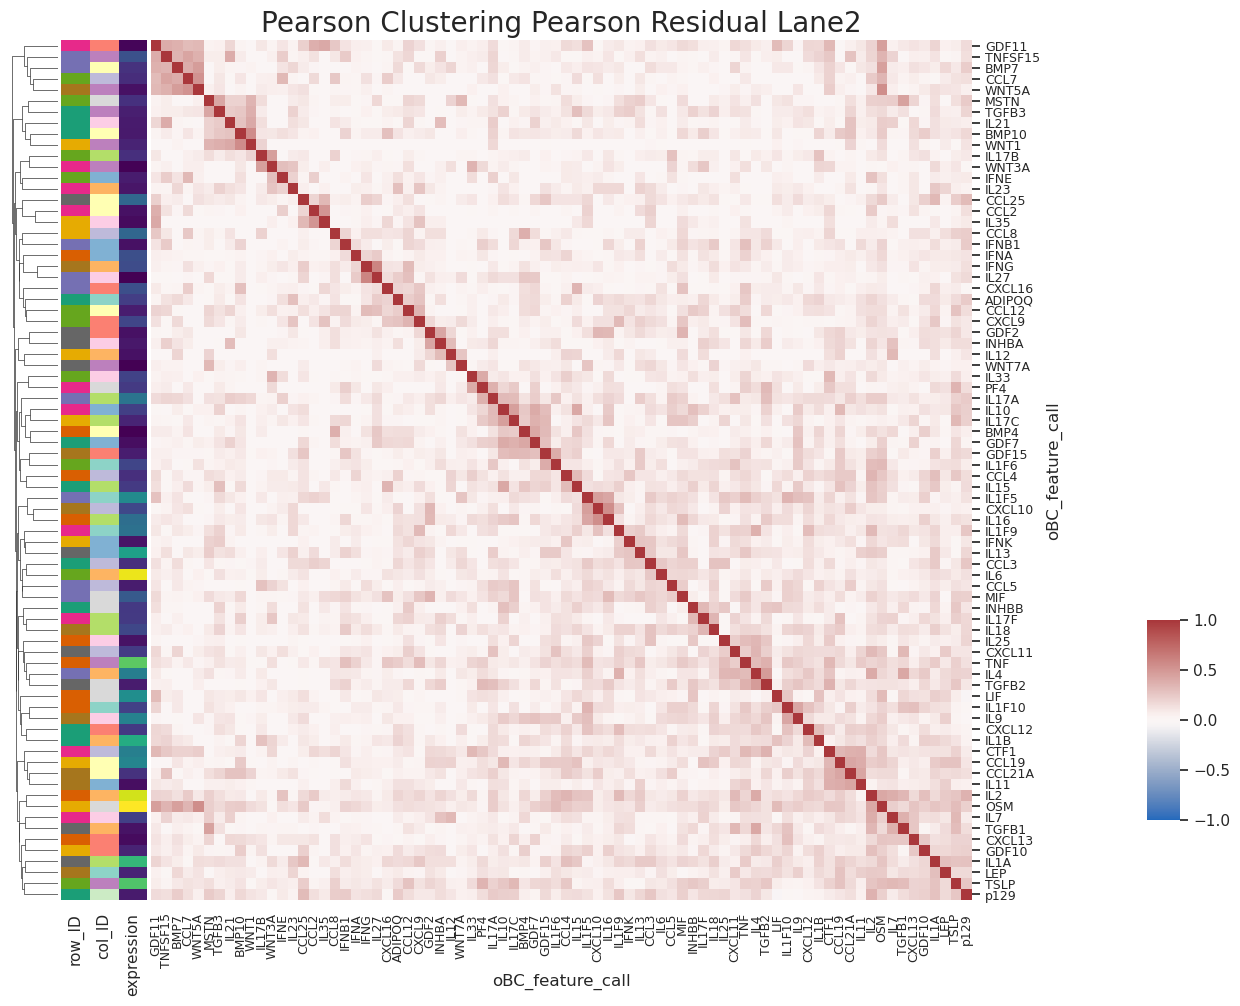

In [133]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(11, 10),
                   row_colors=anno)

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering Pearson Residual Lane2', fontsize=20)

plt.show()

# Correlation Clustering with Pooled Samples

## Clustering using full dataset + normalized counts

In [166]:
adata = dataNorm.copy()
# filter for genes only in X percent of cells
sc.pp.filter_genes(adata, min_cells=len(adata)*0.2)
# Subset anndata to highly-variable genes
adata_hv = adata[:, adata.var['highly_variable']]

# Filter out cells where 'oBC_feature_call' contains '-pool'
adata_filtered = adata_hv[adata_hv.obs['oBC_feature_call'].isin(['IL4','IL6','IL12','IFNA','IFNG',
                                                                'IL4-pool','IL6-pool','IL12-pool','IFNA-pool','IFNG-pool'])]

# Aggregate the data by 'oBC_feature_call' and calculate the mean expression for each group
df = pd.DataFrame(adata_filtered.X.toarray(), index=adata_filtered.obs.index, columns=adata_filtered.var_names)
df['oBC_feature_call'] = adata_filtered.obs['oBC_feature_call']
mean_aggregated = df.groupby('oBC_feature_call').mean()

# Calculate the correlation matrix
correlation_matrix = mean_aggregated.T.corr()

/scratch/lsftmp/9375102.tmpdir/ipykernel_15601/1842125430.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_aggregated = df.groupby('oBC_feature_call').mean()


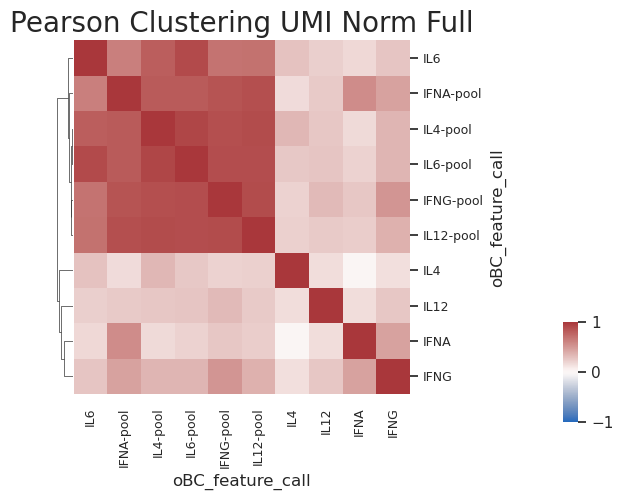

In [169]:
# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='vlag', 
                   vmin=-1, 
                   vmax=1, 
                   dendrogram_ratio=(.05, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={'orientation': 'vertical', 'shrink': 0.5},  # Shrink the colorbar and place it vertically
                   figsize=(5, 5))

# Move the colorbar to the right of the plot
g.cax.set_position([1.05, .2, .03, .2])  # [x, y, width, height] for the colorbar position

# Set smaller font sizes for tick labels specifically
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)  # Adjust x-tick labels
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)  # Adjust y-tick labels
g.ax_heatmap.set_title('Pearson Clustering UMI Norm Full', fontsize=20)

plt.show()